# Why it failed

The main objective of geospatial interpolation is to fill in the gaps between values in 2d space. However, in this situation, I only have reliable, extensive data on the position of the fires, not the intensity or the damage extent. I tried to use the parameters "DiscoveryAcre" which describes the acreage of the fire when it is discovered, but the parameter is not a very good estimator of the severity of the fire and created some interesting interpolations.

Also, the dataset (NIFC) seems to be missing a lot of values...

In [5]:
import shapely
import matplotlib.pyplot as plt
import geopandas
import matplotlib.colors as colors
from scipy.interpolate import griddata
import pandas as pd

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_84478/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [7]:
df = pd.read_csv('/Users/christopher/Documents/Wildfires/drive-download-20230629T154135Z-001/Wildland_Fire_Incident_Locations_csv.csv')

/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_84478/468546253.py:1: DtypeWarning: Columns (6,7,15,16,34,63,66,79,87,88,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/christopher/Documents/Wildfires/drive-download-20230629T154135Z-001/Wildland_Fire_Incident_Locations_csv.csv')


In [4]:
zipfile = ('zip:///Users/christopher/Documents/Wildfires/drive-download-20230629T154135Z-001/Wildland_Fire_Incident_Locations.zip')
df = geopandas.read_file(zipfile)

KeyboardInterrupt: 

In [ ]:
jsonfile = ('/Users/christopher/Downloads/ark28722-s73w23-geojson.json')
world = geopandas.read_file(jsonfile)

In [13]:
len(df)

265312

In [11]:
df["CreatedOnDateTime_dt"].min()

'2014/05/21 04:09:45+00'

In [12]:
df["CreatedOnDateTime_dt"].max()

'2023/06/29 00:47:26+00'

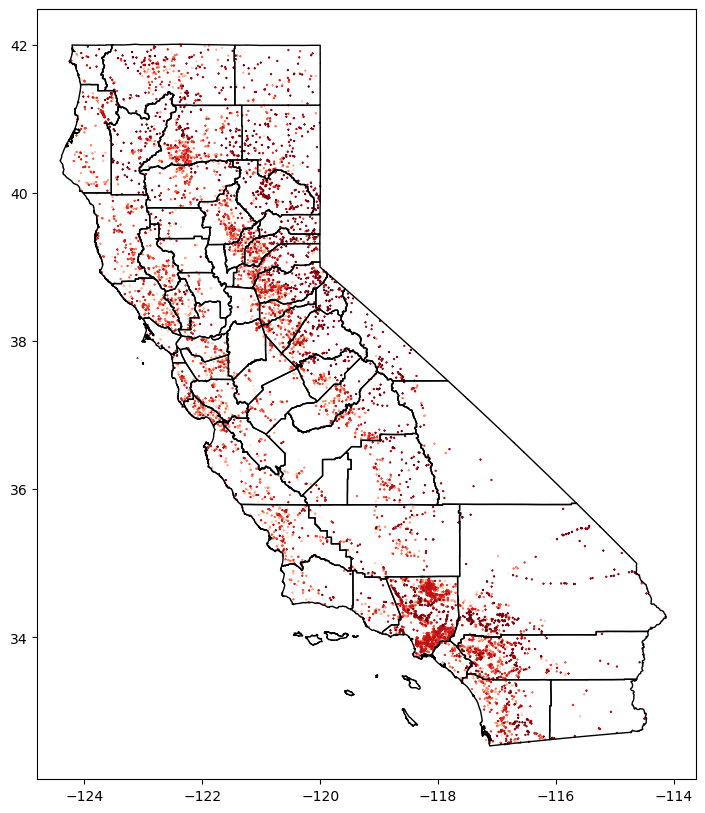

In [126]:
#################################
### PLOTTING YEAR OF INTEREST ###
#################################
year = 2020
gdf = df.query("(POOState == 'US-CA') & (CreatedOnD > '{}-00-00') & (CreatedOnD < '{}-00-00')".format(year, year+1))
ax = gdf.plot(figsize=(10,10), c=gdf["DiscoveryA"], cmap='Reds', marker='x', markersize=0.5)
plt.autoscale(False)
world.to_crs(df.crs).plot(ax = ax, color = "none",edgecolor = 'black', figsize = (10,10))
plt.show()

In [8]:
# https://james-brennan.github.io/posts/fast_gridding_geopandas/

/Users/christopher/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<Axes: >

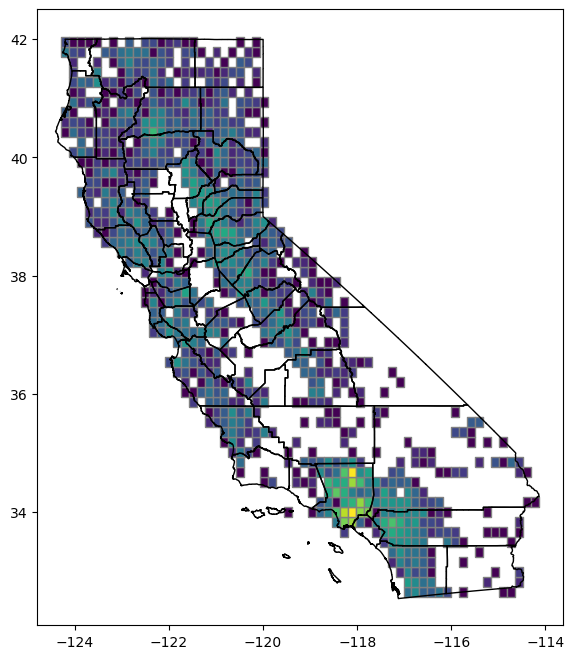

In [209]:
##########################################
### BINNING YEAR OF INTEREST INTO GRID ###
##########################################
import numpy as np
year = 2020
gdf = df.query("(POOState == 'US-CA') & (CreatedOnD > '{}-00-00') & (CreatedOnD < '{}-00-00')".format(year, year+1))
gdf = gdf[~gdf['DiscoveryA'].isnull()]
xmin, ymin, xmax, ymax= gdf.total_bounds
n_cells=60
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = gdf.crs
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
cell = geopandas.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)
merged = geopandas.sjoin(gdf, cell, how='left', op='within')
# make a simple count variable that we can sum
merged['n_fires']=1
# Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = merged.dissolve(by="index_right", aggfunc="count")
# put this into cell
cell.loc[dissolve.index, 'n_fires'] = dissolve.n_fires.values
ax = cell.plot(column='n_fires', figsize=(12, 8),norm=colors.LogNorm(vmin = cell['n_fires'].min(), vmax = cell['n_fires'].max()), cmap='viridis', edgecolor="gray")
plt.autoscale(False)
world.to_crs(cell.crs).plot(ax = ax, color = "none",edgecolor = 'black', figsize = (12,8))

In [206]:
points = np.array((gdf["geometry"].x, gdf["geometry"].y)).T
values = np.array(gdf['DiscoveryA'])
xi = np.array((cell["geometry"].to_crs('epsg:4326').centroid.x, cell["geometry"].to_crs('epsg:4326').centroid.y)).T

/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_41722/2236151193.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xi = np.array((cell["geometry"].to_crs('epsg:4326').centroid.x, cell["geometry"].to_crs('epsg:4326').centroid.y)).T


<Axes: >

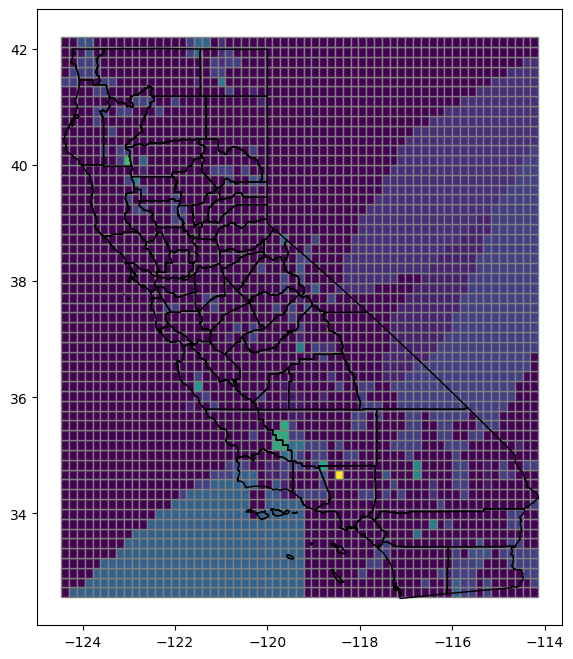

In [203]:
cell["interpolated_value"] = griddata(points, values, xi, method='nearest')
ax = cell.plot(column='interpolated_value', figsize=(12, 8),norm=colors.LogNorm(vmin = cell['interpolated_value'].min(), vmax = cell['interpolated_value'].max()), cmap='viridis', edgecolor="grey")
plt.autoscale(False)
world.to_crs(cell.crs).plot(ax = ax, color = "none", norm=colors.LogNorm(vmin = xi.min(), vmax = xi.max()), edgecolor = 'black', figsize = (12,8))

<Axes: >

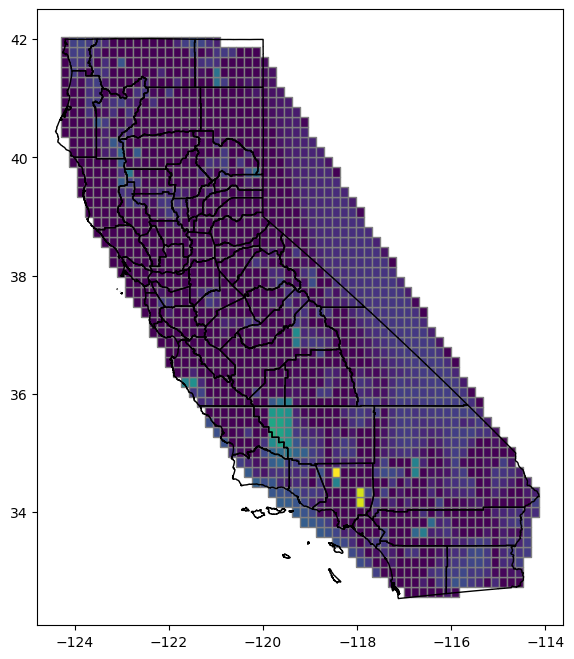

In [204]:
cell["interpolated_value"] = griddata(points, values, xi, method='linear', rescale = True)
ax = cell.plot(column='interpolated_value', figsize=(12, 8),norm=colors.LogNorm(vmin = cell['interpolated_value'].min(), vmax = cell['interpolated_value'].max()), cmap='viridis', edgecolor="grey")
plt.autoscale(False)
world.to_crs(cell.crs).plot(ax = ax, color = "none", norm=colors.LogNorm(vmin = xi.min(), vmax = xi.max()), edgecolor = 'black', figsize = (12,8))

In [187]:
cell['interpolated_value'].min()

0.1

In [200]:
cell['interpolated_value'].isnull().sum()

0

<Axes: >

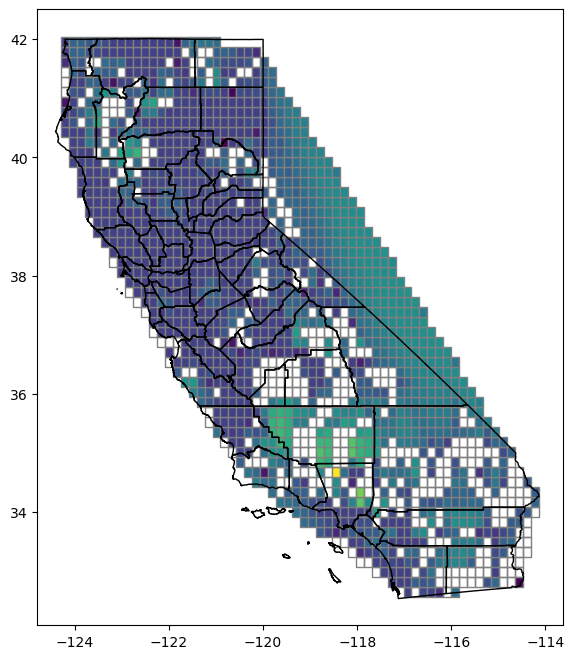

In [205]:
cell["interpolated_value"] = griddata(points, values, xi, method='cubic')
ax = cell.plot(column='interpolated_value', norm=colors.LogNorm(), figsize=(12, 8), cmap='viridis', edgecolor="grey")
plt.autoscale(False)
world.to_crs(cell.crs).plot(ax = ax, color = "none", edgecolor = 'black', figsize = (12,8))

In [179]:
values.min(), values.max()

(0.01, 115997.0)

In [ ]:
###########################################
### RADIAL BASIS FUNCTION INTERPOLATION ###
###########################################

import numpy as np
from scipy.interpolate import Rbf
rng = np.random.default_rng()
x, y, z, d = rng.random((4, 50))
rbfi = Rbf(x, y, z, d)  # radial basis function interpolator instance
xi = yi = zi = np.linspace(0, 1, 20)
di = rbfi(xi, yi, zi)   # interpolated values
di.shape